#**Training d-DNN and e-DNNs using CPR coincidences over the coast**

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import scipy.io
os.getcwd()

## **1. Data**

### **1.1 Data Loading and Organizing** 

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_DPR_land.mat','r')
list(f.keys())

['X_land_trn_detection',
 'X_land_tst_detection',
 'X_rain_land_trn_retrieval',
 'X_rain_land_tst_retrieval',
 'X_snow_land_trn_retrieval',
 'X_snow_land_tst_retrieval',
 'y_land_trn_detection',
 'y_land_tst_detection',
 'y_rain_land_trn_retrieval',
 'y_rain_land_tst_retrieval',
 'y_snow_land_trn_retrieval',
 'y_snow_land_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_land_trn_detection'])
y_trn_detection = np.transpose(f['y_land_trn_detection'])
X1_tst_detection = np.transpose(f['X_land_tst_detection'])
y_tst_detection = np.transpose(f['y_land_tst_detection'])

X1_rain_trn_retrieval = np.transpose(f['X_rain_land_trn_retrieval'])
y_rain_trn_retrieval = np.transpose(f['y_rain_land_trn_retrieval'])
X1_rain_tst_retrieval = np.transpose(f['X_rain_land_tst_retrieval'])
y_rain_tst_retrieval = np.transpose(f['y_rain_land_tst_retrieval'])

X1_snow_trn_retrieval = np.transpose(f['X_snow_land_trn_retrieval'])
y_snow_trn_retrieval = np.transpose(f['y_snow_land_trn_retrieval'])
X1_snow_tst_retrieval = np.transpose(f['X_snow_land_tst_retrieval'])
y_snow_tst_retrieval = np.transpose(f['y_snow_land_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_rain_trn_retrieval.astype('float64')
X1_rain_tst_retrieval.astype('float64')
y_rain_trn_retrieval.astype('float64')
y_rain_tst_retrieval.astype('float64')

X1_snow_trn_retrieval.astype('float64')
X1_snow_tst_retrieval.astype('float64')
y_snow_trn_retrieval.astype('float64')
y_snow_tst_retrieval.astype('float64');

print('Detection sample size:', len(X1_trn_detection))
print('Rainfall Retrieval sample size:', len(X1_rain_trn_retrieval))
print('Snowfall Retrieval size:', len(X1_snow_trn_retrieval))

Detection sample size: 700000
Rainfall Retrieval sample size: 700000
Snowfall Retrieval size: 700000


### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_rain_retrieval = X1_rain_trn_retrieval.mean(axis=0)
X2_rain_trn_retrieval = X1_rain_trn_retrieval-mean_rain_retrieval
std_rain_retrieval = X1_rain_trn_retrieval.std(axis=0)
X_rain_trn_retrieval = X2_rain_trn_retrieval/std_rain_retrieval
X2_rain_tst_retrieval = X1_rain_tst_retrieval-mean_rain_retrieval
X_rain_tst_retrieval = X2_rain_tst_retrieval/std_rain_retrieval

mean_snow_retrieval = X1_snow_trn_retrieval.mean(axis=0)
X2_snow_trn_retrieval = X1_snow_trn_retrieval-mean_snow_retrieval
std_snow_retrieval = X1_snow_trn_retrieval.std(axis=0)
X_snow_trn_retrieval = X2_snow_trn_retrieval/std_snow_retrieval
X2_snow_tst_retrieval = X1_snow_tst_retrieval-mean_snow_retrieval
X_snow_tst_retrieval = X2_snow_tst_retrieval/std_snow_retrieval

In [ ]:
# Removing the outliers
x_snow_lb = 0 #np.percentile(y_snow_trn_retrieval,0.05)
x_snow_ub = np.percentile(y_snow_trn_retrieval,99.95)

x_rain_lb = 0.01 #np.percentile(y_rain_trn_retrieval,0.05)
x_rain_ub = np.percentile(y_rain_trn_retrieval,99.95)

mask_trn_snow = (y_snow_trn_retrieval>=x_snow_lb) & (y_snow_trn_retrieval<=x_snow_ub)
m_trn_snow=mask_trn_snow[:,0]
mask_tst_snow = (y_snow_tst_retrieval>=x_snow_lb) & (y_snow_tst_retrieval<=x_snow_ub)
m_tst_snow=mask_tst_snow[:,0]

mask_trn_rain = (y_rain_trn_retrieval>=x_rain_lb) & (y_rain_trn_retrieval<=x_rain_ub)
m_trn_rain=mask_trn_rain[:,0]
mask_tst_rain = (y_rain_tst_retrieval>=x_rain_lb) & (y_rain_tst_retrieval<=x_rain_ub)
m_tst_rain=mask_tst_rain[:,0]

Xf_snow_trn_detection = np.delete(X_trn_detection, ~m_trn_snow, axis=0)
yf_snow_trn_detection = np.delete(y_trn_detection, ~m_trn_snow, axis=0)
Xf_snow_tst_detection = np.delete(X_tst_detection, ~m_tst_snow, axis=0)
yf_snow_tst_detection = np.delete(y_tst_detection, ~m_tst_snow, axis=0)

Xf_snow_trn_retrieval = np.delete(X_snow_trn_retrieval, ~m_trn_snow, axis=0)
yf_snow_trn_retrieval = np.delete(y_snow_trn_retrieval, ~m_trn_snow, axis=0)
Xf_snow_tst_retrieval = np.delete(X_snow_tst_retrieval, ~m_tst_snow, axis=0)
yf_snow_tst_retrieval = np.delete(y_snow_tst_retrieval, ~m_tst_snow, axis=0)

Xf_rain_trn_detection = np.delete(X_trn_detection, ~m_trn_rain, axis=0)
yf_rain_trn_detection = np.delete(y_trn_detection, ~m_trn_rain, axis=0)
Xf_rain_tst_detection = np.delete(X_tst_detection, ~m_tst_rain, axis=0)
yf_rain_tst_detection = np.delete(y_tst_detection, ~m_tst_rain, axis=0)

Xf_rain_trn_retrieval = np.delete(X_rain_trn_retrieval, ~m_trn_rain, axis=0)
yf_rain_trn_retrieval = np.delete(y_rain_trn_retrieval, ~m_trn_rain, axis=0)
Xf_rain_tst_retrieval = np.delete(X_rain_tst_retrieval, ~m_tst_rain, axis=0)
yf_rain_tst_retrieval = np.delete(y_rain_tst_retrieval, ~m_tst_rain, axis=0)

x_snow_lb, x_snow_ub, x_rain_lb, x_rain_ub

(0.01, 7.3120760111822705, 0.01, 62.83852767944336)

#### Check the balance in the dataset:
To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:
print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==1:
        n_snow+=1
        t_train[i]=2
    if label==2:
        n_rain+=1  
        t_train[i]=1
    if label==3:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==1:
        n_snow+=1
        t_test[i]=2
    if label==2:
        n_rain+=1  
        t_test[i]=1
    if label==3:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 175234
Num. of rainfall: 175879
Num. of clear-sky: 348890

***Testing Dataset:

Num. of snowfall: 75190
Num. of rainfall: 75071
Num. of clear-sky: 149742


In [ ]:
print('\n***Truth Checking - Rain:\n')

n_snow=1
n_rain=1
n_clear=1  
tf_test_rain = np.zeros([yf_rain_tst_detection.shape[0],1])

for i in range(len(Xf_rain_tst_detection)):
    label = yf_rain_tst_detection[i]
    if label==1:
        n_snow+=1
        tf_test_rain[i]=2
    if label==2:
        n_rain+=1  
        tf_test_rain[i]=1
    if label==3:
        n_clear+=1
        tf_test_rain[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Truth Checking - Snow:\n')

n_snow=1
n_rain=1
n_clear=1  
tf_test_snow = np.zeros([yf_snow_tst_detection.shape[0],1])

for i in range(len(Xf_snow_tst_detection)):
    label = yf_snow_tst_detection[i]
    if label==1:
        n_snow+=1
        tf_test_snow[i]=2
    if label==2:
        n_rain+=1  
        tf_test_snow[i]=1
    if label==3:
        n_clear+=1
        tf_test_snow[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)


***Truth Checking - Rain:

Num. of snowfall: 1
Num. of rainfall: 74995
Num. of clear-sky: 1

***Truth Checking - Snow:

Num. of snowfall: 75044
Num. of rainfall: 1
Num. of clear-sky: 1


In [ ]:
from tensorflow.keras.utils import to_categorical

t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**

### **2.1 - Detection Network (d-DNN)** 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

In [ ]:
# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
from tensorflow import keras
callbacks_list = [
#     keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Detection Module):\n')
batch_size1 = 1800
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=300,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/300
312/312 [==============================] - 1s 4ms/step - loss: 0.8027 - recall: 0.3639 - val_loss: 0.5350 - val_recall: 0.7276
Epoch 2/300
312/312 [==============================] - 1s 3ms/step - loss: 0.4242 - recall: 0.8072 - val_loss: 0.3709 - val_recall: 0.8399
Epoch 3/300
312/312 [==============================] - 1s 4ms/step - loss: 0.3404 - recall: 0.8548 - val_loss: 0.3207 - val_recall: 0.8638
Epoch 4/300
312/312 [==============================] - 1s 3ms/step - loss: 0.3000 - recall: 0.8732 - val_loss: 0.2893 - val_recall: 0.8792
Epoch 5/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2748 - recall: 0.8852 - val_loss: 0.2718 - val_recall: 0.8860
Epoch 6/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2594 - recall: 0.8931 - val_loss: 0.2653 - val_recall: 0.8923
Epoch 7/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2492 - recall: 0.8979 - val_loss: 0.2507 - val_recall: 

312/312 [==============================] - 1s 3ms/step - loss: 0.2015 - recall: 0.9200 - val_loss: 0.2146 - val_recall: 0.9144
Epoch 60/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2013 - recall: 0.9202 - val_loss: 0.2077 - val_recall: 0.9173
Epoch 61/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2012 - recall: 0.9203 - val_loss: 0.2033 - val_recall: 0.9194
Epoch 62/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2010 - recall: 0.9205 - val_loss: 0.2057 - val_recall: 0.9183
Epoch 63/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2008 - recall: 0.9204 - val_loss: 0.2031 - val_recall: 0.9196
Epoch 64/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2007 - recall: 0.9206 - val_loss: 0.2102 - val_recall: 0.9162
Epoch 65/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2006 - recall: 0.9205 - val_loss: 0.2047 - val_recall: 0.9185
Epoch 66/300
312/312 [===========

312/312 [==============================] - 1s 3ms/step - loss: 0.1953 - recall: 0.9229 - val_loss: 0.2047 - val_recall: 0.9184
Epoch 118/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1952 - recall: 0.9229 - val_loss: 0.2049 - val_recall: 0.9186
Epoch 119/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1952 - recall: 0.9228 - val_loss: 0.2075 - val_recall: 0.9174
Epoch 120/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1951 - recall: 0.9230 - val_loss: 0.2013 - val_recall: 0.9200
Epoch 121/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1950 - recall: 0.9230 - val_loss: 0.1983 - val_recall: 0.9216
Epoch 122/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1951 - recall: 0.9228 - val_loss: 0.2007 - val_recall: 0.9204
Epoch 123/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1949 - recall: 0.9231 - val_loss: 0.1980 - val_recall: 0.9216
Epoch 124/300
312/312 [====

312/312 [==============================] - 1s 3ms/step - loss: 0.1923 - recall: 0.9239 - val_loss: 0.1957 - val_recall: 0.9226
Epoch 176/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1923 - recall: 0.9240 - val_loss: 0.1976 - val_recall: 0.9214
Epoch 177/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1923 - recall: 0.9240 - val_loss: 0.2022 - val_recall: 0.9194
Epoch 178/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1923 - recall: 0.9239 - val_loss: 0.2028 - val_recall: 0.9195
Epoch 179/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1922 - recall: 0.9239 - val_loss: 0.1973 - val_recall: 0.9218
Epoch 180/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1921 - recall: 0.9241 - val_loss: 0.1985 - val_recall: 0.9214
Epoch 181/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1921 - recall: 0.9241 - val_loss: 0.2026 - val_recall: 0.9197
Epoch 182/300
312/312 [====

312/312 [==============================] - 1s 3ms/step - loss: 0.1902 - recall: 0.9247 - val_loss: 0.1955 - val_recall: 0.9224
Epoch 234/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1902 - recall: 0.9248 - val_loss: 0.1960 - val_recall: 0.9224
Epoch 235/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1902 - recall: 0.9248 - val_loss: 0.2033 - val_recall: 0.9187
Epoch 236/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1901 - recall: 0.9246 - val_loss: 0.1952 - val_recall: 0.9226
Epoch 237/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1902 - recall: 0.9247 - val_loss: 0.1943 - val_recall: 0.9227
Epoch 238/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1901 - recall: 0.9248 - val_loss: 0.1962 - val_recall: 0.9217
Epoch 239/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1901 - recall: 0.9247 - val_loss: 0.2023 - val_recall: 0.9189
Epoch 240/300
312/312 [====

312/312 [==============================] - 1s 3ms/step - loss: 0.1888 - recall: 0.9252 - val_loss: 0.1930 - val_recall: 0.9231
Epoch 292/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1887 - recall: 0.9253 - val_loss: 0.1927 - val_recall: 0.9237
Epoch 293/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1886 - recall: 0.9253 - val_loss: 0.1978 - val_recall: 0.9217
Epoch 294/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1886 - recall: 0.9252 - val_loss: 0.1932 - val_recall: 0.9235
Epoch 295/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1886 - recall: 0.9254 - val_loss: 0.1938 - val_recall: 0.9233
Epoch 296/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1886 - recall: 0.9252 - val_loss: 0.1924 - val_recall: 0.9236
Epoch 297/300
312/312 [==============================] - 1s 3ms/step - loss: 0.1885 - recall: 0.9253 - val_loss: 0.1940 - val_recall: 0.9233
Epoch 298/300
312/312 [====

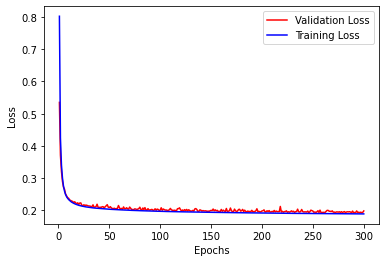

In [ ]:
val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 301)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_label = model_detection.predict(X_tst_detection)
predictions_label_rain = model_detection.predict(Xf_rain_tst_detection)
predictions_label_snow = model_detection.predict(Xf_snow_tst_detection)

In [ ]:
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])
    
y_pred_rain = np.zeros([len(Xf_rain_tst_detection),1])
for i in range(len(Xf_rain_tst_detection)):
    y_pred_rain[i,0] = np.argmax(predictions_label_rain[i])
    
y_pred_snow = np.zeros([len(Xf_snow_tst_detection),1])
for i in range(len(Xf_snow_tst_detection)):
    y_pred_snow[i,0] = np.argmax(predictions_label_snow[i])    

### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 3
precip_r= 2
precip_s= 1

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Land:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Land:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Land:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Land:

Precision:  0.9620453637778359
Accuracy:  0.9665833724494022
Recall (TPR):  0.9710183203135859
False Alarm (FPR):  0.037791734086608346

F1 Score:  0.9665110165680882
----------------------------

 For Snwofall Detection Over Land:

Precision:  0.9711426673310082
Accuracy:  0.9665833724494022
Recall (TPR):  0.9622067111885139
False Alarm (FPR):  0.028980471193272638

F1 Score:  0.9666540382297226
----------------------------

 For Model Detection Over Land:

Precision:  0.9665695667780324
Recall (TPR):  0.9665695667780324

F1 Score:  0.9665695667780324


In [ ]:
model_detection.evaluate(X_tst_detection, t_tst_detection, batch_size = batch_size1)

167/167 [==============================] - 0s 1ms/step - loss: 0.1982 - recall: 0.9209


[0.19818870723247528, 0.9209333062171936]

## **2.2 - Estimation networks (e-DNN)**

In [ ]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Snowfall retrieval** 

In [ ]:
# Parameters
hidden_units = 75
dropout = 0

# LAND
model_retrieval_snow = Sequential()

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))


model_retrieval_snow.add(Dense(1))
model_retrieval_snow.add(Activation('relu'))

In [ ]:
model_retrieval_snow.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 600
history_retrieval_snow = model_retrieval_snow.fit(Xf_snow_trn_retrieval, yf_snow_trn_retrieval, epochs=500,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Snow):

Epoch 1/500
234/234 [==============================] - 1s 3ms/step - loss: 0.8969 - mean_absolute_error: 0.7028 - val_loss: 0.8487 - val_mean_absolute_error: 0.6421
Epoch 2/500
234/234 [==============================] - 1s 3ms/step - loss: 0.7594 - mean_absolute_error: 0.5387 - val_loss: 0.6773 - val_mean_absolute_error: 0.4477
Epoch 3/500
234/234 [==============================] - 1s 2ms/step - loss: 0.6305 - mean_absolute_error: 0.3950 - val_loss: 0.6032 - val_mean_absolute_error: 0.3669
Epoch 4/500
234/234 [==============================] - 1s 2ms/step - loss: 0.5896 - mean_absolute_error: 0.3516 - val_loss: 0.5818 - val_mean_absolute_error: 0.3447
Epoch 5/500
234/234 [==============================] - 1s 2ms/step - loss: 0.5709 - mean_absolute_error: 0.3343 - val_loss: 0.5660 - val_mean_absolute_error: 0.3314
Epoch 6/500
234/234 [==============================] - 1s 2ms/step - loss: 0.5566 - mean_absolute_error: 0.3232 - val_loss: 0.5525 - v

234/234 [==============================] - 0s 2ms/step - loss: 0.4821 - mean_absolute_error: 0.2885 - val_loss: 0.4829 - val_mean_absolute_error: 0.2900
Epoch 51/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4823 - mean_absolute_error: 0.2885 - val_loss: 0.4828 - val_mean_absolute_error: 0.2901
Epoch 52/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4822 - mean_absolute_error: 0.2884 - val_loss: 0.4826 - val_mean_absolute_error: 0.2887
Epoch 53/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4820 - mean_absolute_error: 0.2883 - val_loss: 0.4825 - val_mean_absolute_error: 0.2882
Epoch 54/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4815 - mean_absolute_error: 0.2881 - val_loss: 0.4823 - val_mean_absolute_error: 0.2883
Epoch 55/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4812 - mean_absolute_error: 0.2879 - val_loss: 0.4822 - val_mean_absolute_error: 0.2887
Epoch 56/500
234/

234/234 [==============================] - 0s 2ms/step - loss: 0.4760 - mean_absolute_error: 0.2847 - val_loss: 0.4786 - val_mean_absolute_error: 0.2867
Epoch 100/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4763 - mean_absolute_error: 0.2848 - val_loss: 0.4786 - val_mean_absolute_error: 0.2882
Epoch 101/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4766 - mean_absolute_error: 0.2853 - val_loss: 0.4785 - val_mean_absolute_error: 0.2869
Epoch 102/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4756 - mean_absolute_error: 0.2846 - val_loss: 0.4785 - val_mean_absolute_error: 0.2870
Epoch 103/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4762 - mean_absolute_error: 0.2846 - val_loss: 0.4784 - val_mean_absolute_error: 0.2857
Epoch 104/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4763 - mean_absolute_error: 0.2844 - val_loss: 0.4784 - val_mean_absolute_error: 0.2878
Epoch 105/50

234/234 [==============================] - 0s 2ms/step - loss: 0.4721 - mean_absolute_error: 0.2826 - val_loss: 0.4768 - val_mean_absolute_error: 0.2858
Epoch 149/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4726 - mean_absolute_error: 0.2829 - val_loss: 0.4768 - val_mean_absolute_error: 0.2861
Epoch 150/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4726 - mean_absolute_error: 0.2827 - val_loss: 0.4768 - val_mean_absolute_error: 0.2866
Epoch 151/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4722 - mean_absolute_error: 0.2827 - val_loss: 0.4768 - val_mean_absolute_error: 0.2860
Epoch 152/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4725 - mean_absolute_error: 0.2828 - val_loss: 0.4767 - val_mean_absolute_error: 0.2856
Epoch 153/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4727 - mean_absolute_error: 0.2827 - val_loss: 0.4768 - val_mean_absolute_error: 0.2863
Epoch 154/50

234/234 [==============================] - 0s 2ms/step - loss: 0.4702 - mean_absolute_error: 0.2817 - val_loss: 0.4762 - val_mean_absolute_error: 0.2836
Epoch 198/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4704 - mean_absolute_error: 0.2817 - val_loss: 0.4762 - val_mean_absolute_error: 0.2854
Epoch 199/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4698 - mean_absolute_error: 0.2815 - val_loss: 0.4762 - val_mean_absolute_error: 0.2858
Epoch 200/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4698 - mean_absolute_error: 0.2819 - val_loss: 0.4761 - val_mean_absolute_error: 0.2845
Epoch 201/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4701 - mean_absolute_error: 0.2816 - val_loss: 0.4761 - val_mean_absolute_error: 0.2858
Epoch 202/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4701 - mean_absolute_error: 0.2817 - val_loss: 0.4761 - val_mean_absolute_error: 0.2844
Epoch 203/50

234/234 [==============================] - 0s 2ms/step - loss: 0.4682 - mean_absolute_error: 0.2809 - val_loss: 0.4759 - val_mean_absolute_error: 0.2852
Epoch 247/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4683 - mean_absolute_error: 0.2809 - val_loss: 0.4759 - val_mean_absolute_error: 0.2837
Epoch 248/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4680 - mean_absolute_error: 0.2807 - val_loss: 0.4759 - val_mean_absolute_error: 0.2851
Epoch 249/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4682 - mean_absolute_error: 0.2807 - val_loss: 0.4759 - val_mean_absolute_error: 0.2840
Epoch 250/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4680 - mean_absolute_error: 0.2805 - val_loss: 0.4759 - val_mean_absolute_error: 0.2846
Epoch 251/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4680 - mean_absolute_error: 0.2807 - val_loss: 0.4761 - val_mean_absolute_error: 0.2869
Epoch 252/50

234/234 [==============================] - 0s 2ms/step - loss: 0.4661 - mean_absolute_error: 0.2802 - val_loss: 0.4758 - val_mean_absolute_error: 0.2835
Epoch 296/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4663 - mean_absolute_error: 0.2797 - val_loss: 0.4758 - val_mean_absolute_error: 0.2839
Epoch 297/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4661 - mean_absolute_error: 0.2800 - val_loss: 0.4758 - val_mean_absolute_error: 0.2844
Epoch 298/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4665 - mean_absolute_error: 0.2798 - val_loss: 0.4758 - val_mean_absolute_error: 0.2836
Epoch 299/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4659 - mean_absolute_error: 0.2800 - val_loss: 0.4759 - val_mean_absolute_error: 0.2855
Epoch 300/500
234/234 [==============================] - 0s 2ms/step - loss: 0.4660 - mean_absolute_error: 0.2800 - val_loss: 0.4758 - val_mean_absolute_error: 0.2851
Epoch 301/50

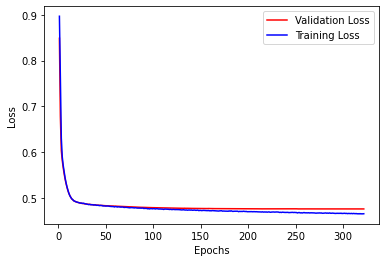

In [ ]:
val_loss = history_retrieval_snow.history["val_loss"]
loss = history_retrieval_snow.history["loss"]

epochs = range(1, 323)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_snow = model_retrieval_snow.predict(Xf_snow_tst_retrieval)

In [ ]:
model_retrieval_snow.evaluate(Xf_snow_tst_retrieval, yf_snow_tst_retrieval, batch_size = batch_size2)

126/126 [==============================] - 0s 554us/step - loss: 0.4800 - mean_absolute_error: 0.2873


[0.4800403118133545, 0.2872605323791504]

### **2.2.2 Rainfall retrieval** 

In [ ]:
# Parameters
hidden_units = 75
dropout = 0

# LAND
model_retrieval_rain = Sequential()

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(1))
model_retrieval_rain.add(Activation('relu'))

In [ ]:
model_retrieval_rain.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = mean_absolute_error,
              metrics= root_mean_squared_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Rain):\n')
batch_size2 = 600
history_retrieval_rain = model_retrieval_rain.fit(Xf_rain_trn_retrieval, yf_rain_trn_retrieval, epochs=800,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Rain):

Epoch 1/800
235/235 [==============================] - 1s 2ms/step - loss: 1.9639 - root_mean_squared_error: 4.1201 - val_loss: 1.8044 - val_root_mean_squared_error: 3.9772
Epoch 2/800
235/235 [==============================] - 0s 2ms/step - loss: 1.6171 - root_mean_squared_error: 3.7729 - val_loss: 1.4963 - val_root_mean_squared_error: 3.6213
Epoch 3/800
235/235 [==============================] - 0s 2ms/step - loss: 1.4312 - root_mean_squared_error: 3.4966 - val_loss: 1.4109 - val_root_mean_squared_error: 3.4336
Epoch 4/800
235/235 [==============================] - 1s 2ms/step - loss: 1.3857 - root_mean_squared_error: 3.3993 - val_loss: 1.3811 - val_root_mean_squared_error: 3.3747
Epoch 5/800
235/235 [==============================] - 1s 2ms/step - loss: 1.3605 - root_mean_squared_error: 3.3576 - val_loss: 1.3569 - val_root_mean_squared_error: 3.3447
Epoch 6/800
235/235 [==============================] - 0s 2ms/step - loss: 1.3379 - root_mean_

Epoch 48/800
235/235 [==============================] - 0s 2ms/step - loss: 1.2074 - root_mean_squared_error: 3.1470 - val_loss: 1.2038 - val_root_mean_squared_error: 3.1097
Epoch 49/800
235/235 [==============================] - 0s 2ms/step - loss: 1.2068 - root_mean_squared_error: 3.1396 - val_loss: 1.2028 - val_root_mean_squared_error: 3.1072
Epoch 50/800
235/235 [==============================] - 0s 2ms/step - loss: 1.2062 - root_mean_squared_error: 3.1373 - val_loss: 1.2023 - val_root_mean_squared_error: 3.1058
Epoch 51/800
235/235 [==============================] - 0s 2ms/step - loss: 1.2056 - root_mean_squared_error: 3.1376 - val_loss: 1.2018 - val_root_mean_squared_error: 3.1050
Epoch 52/800
235/235 [==============================] - 0s 2ms/step - loss: 1.2050 - root_mean_squared_error: 3.1411 - val_loss: 1.2011 - val_root_mean_squared_error: 3.1019
Epoch 53/800
235/235 [==============================] - 0s 2ms/step - loss: 1.2044 - root_mean_squared_error: 3.1277 - val_loss: 1

235/235 [==============================] - 0s 2ms/step - loss: 1.1871 - root_mean_squared_error: 3.1371 - val_loss: 1.1854 - val_root_mean_squared_error: 3.1023
Epoch 96/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1868 - root_mean_squared_error: 3.1298 - val_loss: 1.1851 - val_root_mean_squared_error: 3.0914
Epoch 97/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1865 - root_mean_squared_error: 3.1301 - val_loss: 1.1849 - val_root_mean_squared_error: 3.1000
Epoch 98/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1862 - root_mean_squared_error: 3.1239 - val_loss: 1.1850 - val_root_mean_squared_error: 3.1070
Epoch 99/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1859 - root_mean_squared_error: 3.1287 - val_loss: 1.1844 - val_root_mean_squared_error: 3.0993
Epoch 100/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1856 - root_mean_squared_error: 3.1231 - val_loss: 1.1842 - val_

Epoch 142/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1766 - root_mean_squared_error: 3.1239 - val_loss: 1.1771 - val_root_mean_squared_error: 3.0942
Epoch 143/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1765 - root_mean_squared_error: 3.1126 - val_loss: 1.1773 - val_root_mean_squared_error: 3.1046
Epoch 144/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1763 - root_mean_squared_error: 3.1312 - val_loss: 1.1772 - val_root_mean_squared_error: 3.1017
Epoch 145/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1761 - root_mean_squared_error: 3.1269 - val_loss: 1.1771 - val_root_mean_squared_error: 3.1041
Epoch 146/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1760 - root_mean_squared_error: 3.1365 - val_loss: 1.1767 - val_root_mean_squared_error: 3.0983
Epoch 147/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1757 - root_mean_squared_error: 3.1294 - val_l

Epoch 189/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1699 - root_mean_squared_error: 3.1222 - val_loss: 1.1730 - val_root_mean_squared_error: 3.0993
Epoch 190/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1698 - root_mean_squared_error: 3.1198 - val_loss: 1.1727 - val_root_mean_squared_error: 3.0972
Epoch 191/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1697 - root_mean_squared_error: 3.1214 - val_loss: 1.1728 - val_root_mean_squared_error: 3.0961
Epoch 192/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1695 - root_mean_squared_error: 3.1255 - val_loss: 1.1729 - val_root_mean_squared_error: 3.0981
Epoch 193/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1694 - root_mean_squared_error: 3.1115 - val_loss: 1.1729 - val_root_mean_squared_error: 3.1025
Epoch 194/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1693 - root_mean_squared_error: 3.1191 - val_l

Epoch 236/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1646 - root_mean_squared_error: 3.1069 - val_loss: 1.1703 - val_root_mean_squared_error: 3.1014
Epoch 237/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1645 - root_mean_squared_error: 3.1130 - val_loss: 1.1710 - val_root_mean_squared_error: 3.1094
Epoch 238/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1644 - root_mean_squared_error: 3.1215 - val_loss: 1.1703 - val_root_mean_squared_error: 3.1001
Epoch 239/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1643 - root_mean_squared_error: 3.1147 - val_loss: 1.1701 - val_root_mean_squared_error: 3.0978
Epoch 240/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1642 - root_mean_squared_error: 3.1099 - val_loss: 1.1700 - val_root_mean_squared_error: 3.0986
Epoch 241/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1641 - root_mean_squared_error: 3.1141 - val_l

Epoch 283/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1602 - root_mean_squared_error: 3.1075 - val_loss: 1.1682 - val_root_mean_squared_error: 3.0925
Epoch 284/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1601 - root_mean_squared_error: 3.1059 - val_loss: 1.1684 - val_root_mean_squared_error: 3.1007
Epoch 285/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1600 - root_mean_squared_error: 3.1013 - val_loss: 1.1683 - val_root_mean_squared_error: 3.1004
Epoch 286/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1599 - root_mean_squared_error: 3.1122 - val_loss: 1.1681 - val_root_mean_squared_error: 3.0952
Epoch 287/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1598 - root_mean_squared_error: 3.0992 - val_loss: 1.1689 - val_root_mean_squared_error: 3.1077
Epoch 288/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1597 - root_mean_squared_error: 3.1024 - val_l

Epoch 330/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1560 - root_mean_squared_error: 3.1110 - val_loss: 1.1670 - val_root_mean_squared_error: 3.0919
Epoch 331/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1560 - root_mean_squared_error: 3.1146 - val_loss: 1.1669 - val_root_mean_squared_error: 3.0974
Epoch 332/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1558 - root_mean_squared_error: 3.1027 - val_loss: 1.1673 - val_root_mean_squared_error: 3.1039
Epoch 333/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1558 - root_mean_squared_error: 3.0959 - val_loss: 1.1669 - val_root_mean_squared_error: 3.1011
Epoch 334/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1557 - root_mean_squared_error: 3.0989 - val_loss: 1.1674 - val_root_mean_squared_error: 3.1075
Epoch 335/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1556 - root_mean_squared_error: 3.1008 - val_l

235/235 [==============================] - 0s 2ms/step - loss: 1.1523 - root_mean_squared_error: 3.0941 - val_loss: 1.1664 - val_root_mean_squared_error: 3.1045
Epoch 377/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1522 - root_mean_squared_error: 3.0874 - val_loss: 1.1659 - val_root_mean_squared_error: 3.0975
Epoch 378/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1521 - root_mean_squared_error: 3.0969 - val_loss: 1.1659 - val_root_mean_squared_error: 3.0971
Epoch 379/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1520 - root_mean_squared_error: 3.0889 - val_loss: 1.1658 - val_root_mean_squared_error: 3.0922
Epoch 380/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1520 - root_mean_squared_error: 3.0875 - val_loss: 1.1664 - val_root_mean_squared_error: 3.1033
Epoch 381/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1519 - root_mean_squared_error: 3.0889 - val_loss: 1.1660 - 

Epoch 423/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1487 - root_mean_squared_error: 3.0917 - val_loss: 1.1650 - val_root_mean_squared_error: 3.0990
Epoch 424/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1486 - root_mean_squared_error: 3.0956 - val_loss: 1.1653 - val_root_mean_squared_error: 3.0995
Epoch 425/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1485 - root_mean_squared_error: 3.0881 - val_loss: 1.1651 - val_root_mean_squared_error: 3.0984
Epoch 426/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1484 - root_mean_squared_error: 3.0853 - val_loss: 1.1652 - val_root_mean_squared_error: 3.0979
Epoch 427/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1484 - root_mean_squared_error: 3.0891 - val_loss: 1.1649 - val_root_mean_squared_error: 3.0958
Epoch 428/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1482 - root_mean_squared_error: 3.0839 - val_l

Epoch 470/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1451 - root_mean_squared_error: 3.0923 - val_loss: 1.1649 - val_root_mean_squared_error: 3.0863
Epoch 471/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1451 - root_mean_squared_error: 3.0852 - val_loss: 1.1645 - val_root_mean_squared_error: 3.1000
Epoch 472/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1450 - root_mean_squared_error: 3.0690 - val_loss: 1.1643 - val_root_mean_squared_error: 3.0960
Epoch 473/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1449 - root_mean_squared_error: 3.0802 - val_loss: 1.1647 - val_root_mean_squared_error: 3.0891
Epoch 474/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1449 - root_mean_squared_error: 3.0738 - val_loss: 1.1646 - val_root_mean_squared_error: 3.1003
Epoch 475/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1447 - root_mean_squared_error: 3.0812 - val_l

Epoch 517/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1418 - root_mean_squared_error: 3.0715 - val_loss: 1.1635 - val_root_mean_squared_error: 3.0905
Epoch 518/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1417 - root_mean_squared_error: 3.0658 - val_loss: 1.1638 - val_root_mean_squared_error: 3.0982
Epoch 519/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1416 - root_mean_squared_error: 3.0730 - val_loss: 1.1639 - val_root_mean_squared_error: 3.1003
Epoch 520/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1415 - root_mean_squared_error: 3.0657 - val_loss: 1.1635 - val_root_mean_squared_error: 3.0929
Epoch 521/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1415 - root_mean_squared_error: 3.0639 - val_loss: 1.1632 - val_root_mean_squared_error: 3.0912
Epoch 522/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1414 - root_mean_squared_error: 3.0713 - val_l

Epoch 564/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1386 - root_mean_squared_error: 3.0671 - val_loss: 1.1635 - val_root_mean_squared_error: 3.1040
Epoch 565/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1386 - root_mean_squared_error: 3.0790 - val_loss: 1.1633 - val_root_mean_squared_error: 3.1003
Epoch 566/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1385 - root_mean_squared_error: 3.0662 - val_loss: 1.1628 - val_root_mean_squared_error: 3.0883
Epoch 567/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1384 - root_mean_squared_error: 3.0702 - val_loss: 1.1626 - val_root_mean_squared_error: 3.0898
Epoch 568/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1383 - root_mean_squared_error: 3.0563 - val_loss: 1.1631 - val_root_mean_squared_error: 3.0990
Epoch 569/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1383 - root_mean_squared_error: 3.0694 - val_l

Epoch 611/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1356 - root_mean_squared_error: 3.0651 - val_loss: 1.1623 - val_root_mean_squared_error: 3.0925
Epoch 612/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1356 - root_mean_squared_error: 3.0544 - val_loss: 1.1624 - val_root_mean_squared_error: 3.0916
Epoch 613/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1354 - root_mean_squared_error: 3.0718 - val_loss: 1.1625 - val_root_mean_squared_error: 3.0952
Epoch 614/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1354 - root_mean_squared_error: 3.0524 - val_loss: 1.1621 - val_root_mean_squared_error: 3.0890
Epoch 615/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1354 - root_mean_squared_error: 3.0567 - val_loss: 1.1626 - val_root_mean_squared_error: 3.0919
Epoch 616/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1353 - root_mean_squared_error: 3.0635 - val_l

Epoch 658/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1327 - root_mean_squared_error: 3.0459 - val_loss: 1.1621 - val_root_mean_squared_error: 3.0930
Epoch 659/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1326 - root_mean_squared_error: 3.0479 - val_loss: 1.1621 - val_root_mean_squared_error: 3.0947
Epoch 660/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1326 - root_mean_squared_error: 3.0541 - val_loss: 1.1618 - val_root_mean_squared_error: 3.0889
Epoch 661/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1325 - root_mean_squared_error: 3.0571 - val_loss: 1.1621 - val_root_mean_squared_error: 3.0928
Epoch 662/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1324 - root_mean_squared_error: 3.0479 - val_loss: 1.1625 - val_root_mean_squared_error: 3.0945
Epoch 663/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1324 - root_mean_squared_error: 3.0580 - val_l

Epoch 705/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1299 - root_mean_squared_error: 3.0511 - val_loss: 1.1618 - val_root_mean_squared_error: 3.0897
Epoch 706/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1299 - root_mean_squared_error: 3.0474 - val_loss: 1.1616 - val_root_mean_squared_error: 3.0920
Epoch 707/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1298 - root_mean_squared_error: 3.0507 - val_loss: 1.1619 - val_root_mean_squared_error: 3.0886
Epoch 708/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1298 - root_mean_squared_error: 3.0494 - val_loss: 1.1616 - val_root_mean_squared_error: 3.0866
Epoch 709/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1297 - root_mean_squared_error: 3.0419 - val_loss: 1.1614 - val_root_mean_squared_error: 3.0875
Epoch 710/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1296 - root_mean_squared_error: 3.0460 - val_l

Epoch 752/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1273 - root_mean_squared_error: 3.0431 - val_loss: 1.1614 - val_root_mean_squared_error: 3.0908
Epoch 753/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1272 - root_mean_squared_error: 3.0436 - val_loss: 1.1618 - val_root_mean_squared_error: 3.0826
Epoch 754/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1272 - root_mean_squared_error: 3.0367 - val_loss: 1.1616 - val_root_mean_squared_error: 3.0872
Epoch 755/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1271 - root_mean_squared_error: 3.0361 - val_loss: 1.1615 - val_root_mean_squared_error: 3.0901
Epoch 756/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1271 - root_mean_squared_error: 3.0304 - val_loss: 1.1614 - val_root_mean_squared_error: 3.0886
Epoch 757/800
235/235 [==============================] - 0s 2ms/step - loss: 1.1270 - root_mean_squared_error: 3.0363 - val_l

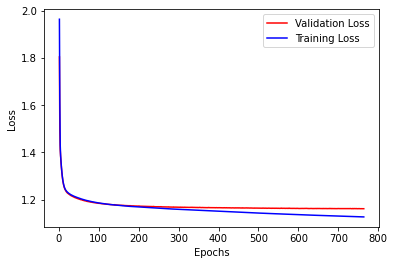

In [ ]:
val_loss = history_retrieval_rain.history["val_loss"]
loss = history_retrieval_rain.history["loss"]

epochs = range(1, 765)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_rain = model_retrieval_rain.predict(Xf_rain_tst_retrieval)

In [ ]:
model_retrieval_rain.evaluate(Xf_rain_tst_retrieval, yf_rain_tst_retrieval, batch_size = batch_size2)

125/125 [==============================] - 0s 582us/step - loss: 1.1995 - root_mean_squared_error: 3.2355


[1.1995289325714111, 3.2354979515075684]

# **3. Saving the models**

In [ ]:
import scipy
from scipy.io import savemat

model_detection.save('Models\DPR\Land\model_dtc',save_format='h5')
model_retrieval_snow.save('Models\DPR\Land\model_snow',save_format='h5')
model_retrieval_rain.save('Models\DPR\Land\model_rain',save_format='h5')

fp_DPR_land = 'Models/DPR/Land/files_DPR_land.mat'
scipy.io.savemat(fp_DPR_land, {'mean_detection_DPR_land': mean_detection,'std_detection_DPR_land':std_detection,
                               'mean_snow_retrieval_DPR_land': mean_snow_retrieval,'std_snow_retrieval_DPR_land':std_snow_retrieval,
                               'mean_rain_retrieval_DPR_land': mean_rain_retrieval,'std_rain_retrieval_DPR_land':std_rain_retrieval})
